# Practical Bayesian Optimization of Machine Learning Algorithm

**Auteurs du projet**: Vincent LE MEUR, Thomas Levy,Timothée Watrigant

## Implémentation

### Contexte

Nous avons initialement étudié l'implémentation de l'auteur de l'article appelée [Spearmint](https://github.com/JasperSnoek/spearmint).

Nous avons rencontré les difficultés suivantes:
* Implémentation ancienne, plus mise à jour qui repose sur Python2: Python3 est devenu la version Python principale actuelle.
* Librairies difficilement integrables sous Windows et Mac: Nous avons du faire tourner spearmint sous une machine virtuelle Linux (Distribution Ubuntu 16.04).

Au final, cette implementation devenait complexe à utiliser et à étendre en particulier dans un Notebook Python.

Nous avons donc étudié une autre implémentation (cf https://github.com/thuijskens/bayesian-optimization) que nous avons adapté dans le cadre de notre étude.

### Notre implémentation
Dans notre implémentation, nous avons appliqué un processus Gaussien avec le kernel ARD 5/2 et la fonction d'acquisition Expected Improvment.
Dans un soucis de simplicité, nous n'avons pas utilisé de parallélisation.

Nous avons mis en application cet algorithme d'optimisation sur un problème de classification multiclasse. 
Notre choix s'est porté vers le célèbre dataset iris. 

Nous avons optimisé deux hyperparamètres pour deux algorithmes de Machine Learning de la librairie scikit learn:
      SVM classifier (SVC) et Stochastic Gradient Descent classifier (SGDClassifier avec loss='hinge' qui correspond à un algo SVM linéaire).
 
 Pour le SGDclassifier les deux hyperparamètres sont :
 - l1_ratio un paramètre d'élasticité
 - alpha, une constante de régularisation
 
Pour le SVC les deux hyperparamètres sont : 
- C, un terme de pénalité de la fonction d'erreur
- $\gamma$ coefficient propre au kernel utilisé

En plus du dataset iris, nous avons également utilisé une fonction sklearn "make_classification" qui génére aléatoirement un nouveau dataset.

En outre, nous avons utilisé les fonctions de sklearn pour la définition du kernel Mattern 5/2, et pour le processus gaussien. 

On commence par définir les fonctions utiles pour calculer l'optimisation bayésienne (kernel, expected improvment, détermination du prochain point d'application) puis des fonctions propres à l'affichage des figures.

### Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import datasets
from matplotlib import rc
%matplotlib inline

### Définition de la fonction d'acquisition "Expected Improvement"
Paramètres:
* x: type array, point à calculer
* gaussian_process: Le processus gaussien entraîné précedemment sur les hyperparamètres    
* evaluated_loss: Numpy array contenant les valeurs de la fonction de perte précédemment évaluées
* greater_is_better: Boolean indiquant si il s'agit de maximiser ou minimiser la fonction de perte
* n_params: int indiquant la dimension des hyperparamètres  

In [2]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


### Fonction déterminant le prochain point d'acquisition :
Params:
* acquisition_func: fonction d'acquisition à optimiser
* gaussian_process: Le processus gaussien entraîné précedemment sur les hyperparamètres
* evaluated_loss: Numpy array contenant les valeurs de la fonction de perte précédemment évaluées
* greater_is_better: Boolean indiquant si il s'agit de maximiser ou minimiser la fonction de perte
* bounds: Tuple indiquant les limites de définition pour l'"optimiseur" L-BFGS
* n_restarts: int indiquant le nombre d'itération effectuées sur le minimiseur avec des valeurs différentes

In [3]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):

    # Initialisation : 
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))
        # Condition de changement d'hyperparamètres : 
        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

### Fonction optimisant la fonction de perte à l'aide de processus Gaussien
Params:
* n_iters: int indiquant le nombre d'itérations à utiliser
* sample_loss: fonction à optimiser
* bounds: Array indiquant les bornes de la fonction de perte
* x0: array définissant des points initiaux où évaluer la fonction de perte. Si x0=None ces points sont choisis de manière aléatoire
* n_pre_samples: int indiquant le nombre de points initiaux si x0=None
* gp_params: dictionaire indiquant les hyperparamètres à passer au processus Gaussien.
* random_search: Boolean indiquant si on utilise une recherche aléatoire ou une optimisation L-BFGS sur la fonction d'acquisition
* alpha: double indiquant la variance associé au terme d'erreur du Processus Gaussien
* epsilon: double indiquant le niveau de tolérance pour l'évaluation des float    


In [4]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern(nu=5/2)
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Mise en place des hyperparamètres suivants : 
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Mise en place de la fonction de perte pour de nouveaux paramètres : 
        cv_score = sample_loss(next_sample)

        # Mise à jours des listes
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Mise à jour des sorties
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

### Fonctions d'affichage des résultats à chaque itération
Les fonctions suivantes vont servir à créer des graphiques pour illustrer la mise en place de l'optimisation.
Les graphiques obtenus vont représenter en abscisse et ordonnées nos différents hyperparamètres avec un code couleur correspondant à des isovaleurs de la fonction de perte et de l'Expected Improovement respectivement.
Params:
* first_param_grid: Array qui contient la grille des points à aficher pour le premier paramètre.
* sampled_params: Points pour lesquels la valeur de la fonction de perte est calculée.
* sampled_loss: Fonction loss utilisée
* first_iter: Premiere itération à afficher
* alpha: Variance de l'erreur dans le modele GP
* greater_is_better: boolean indique si on veut maximiser ou minimiser la fonction loss.
* true_y: array contenant la veritable valeur de la loss pour affichage comparé. 
* second_param_grid: Array qui contient la grille des points à aficher pour le second paramètre.
* param_dims_to_plot: list des indices de `sampled_params` contenant le premier et le second parametre.
* optimum: valeur maximale de la fonction loss


In [5]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
 

    # Create the GPMatern
    kernel = gp.kernels.Matern(nu=5/2)
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
             plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2

def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("hyper-param1")
    ax1.set_ylabel("hyper-param2")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("hyper-param1")
    ax2.set_ylabel("hyper-param2")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='red', s=150)

    return fig, ax1, ax2


## 1. SGDClassifier

Nous allons ici tenter d'optimiser les hyperparamètres de l'algorithme de classification de sklearn SGDClassifier avec loss='hinge' sur notre dataset iris :

In [6]:
# Récupération des données
data,target = load_iris(True)
# On définit ici notre classifieur :
def sample_loss(params):
    return cross_val_score(SGDClassifier(alpha=10 **params[0], l1_ratio=params[1],loss='hinge'),
                           X=data, y=target, cv=3).mean()

On cherche une valeur optimale des hyperparamètres indiquée par une étoile rouge sur nos futurs graphes.

In [7]:
# Espace dans lequel va évoluer nos hyperparamètres
alphas = np.linspace(-4,2,100)
l1_ratios = np.linspace(0,1,100)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[alpha, l1_ratio] for alpha in alphas for l1_ratio in l1_ratios])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([-2.48484848,  0.91919192])

On mets en place ci-dessous notre optimisation bayésienne : 

In [8]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-4,2], [0,1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=1000)

On affiche les résultats obtenus par l'optimisation bayésienne pour la fonction de perte et l'Expected Improovement pour chaque itération : 

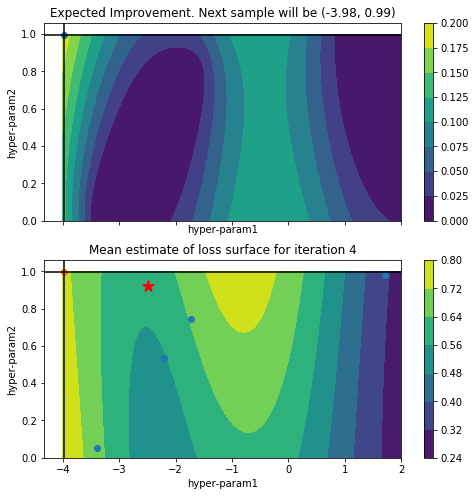

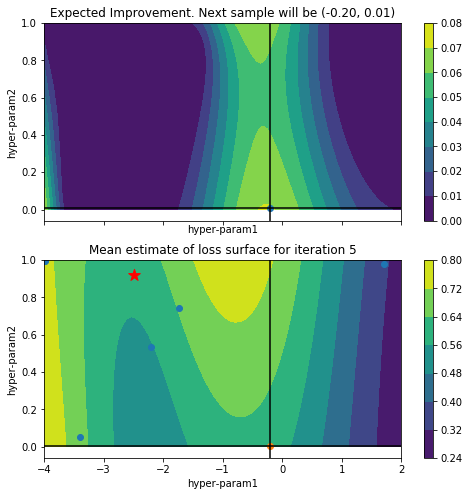

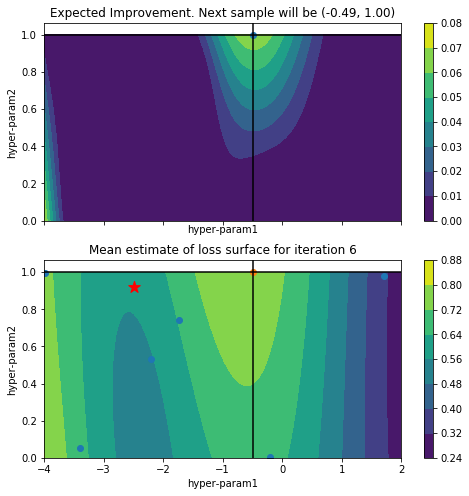

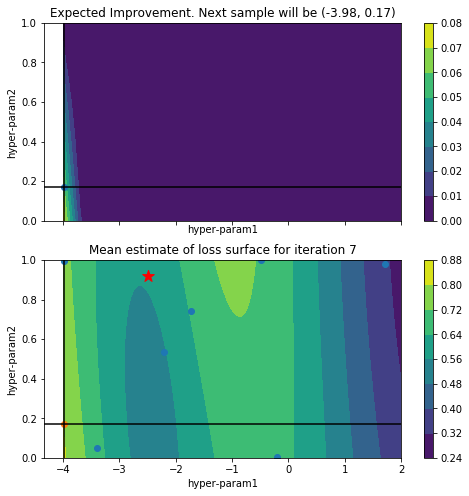

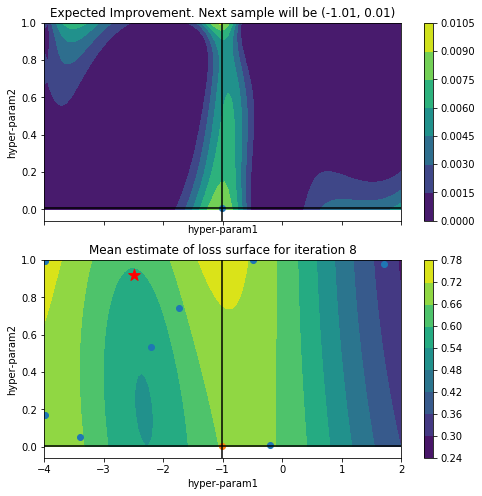

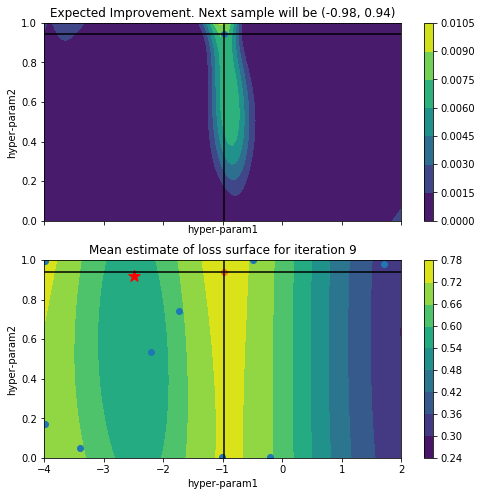

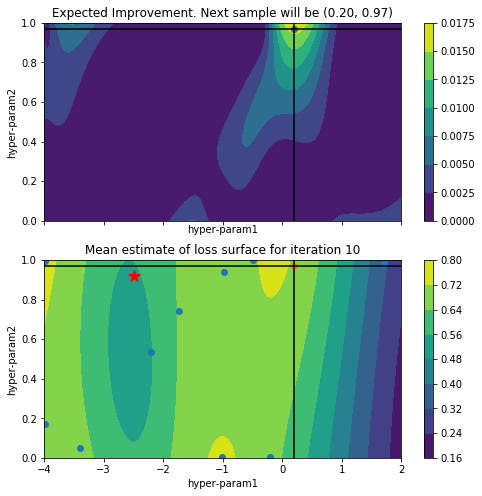

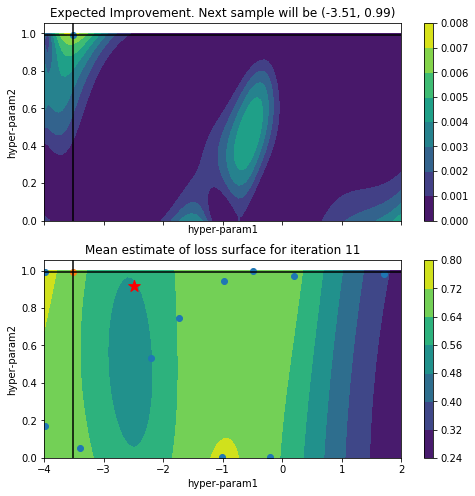

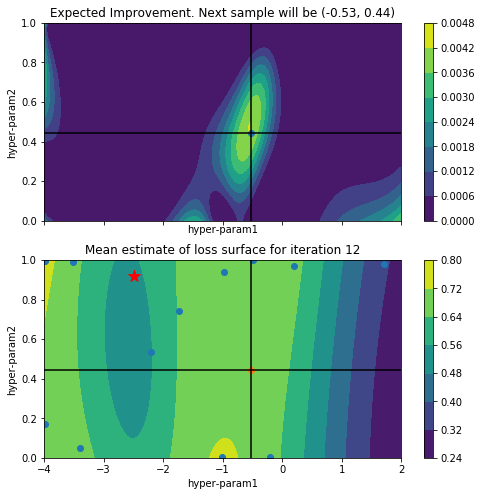

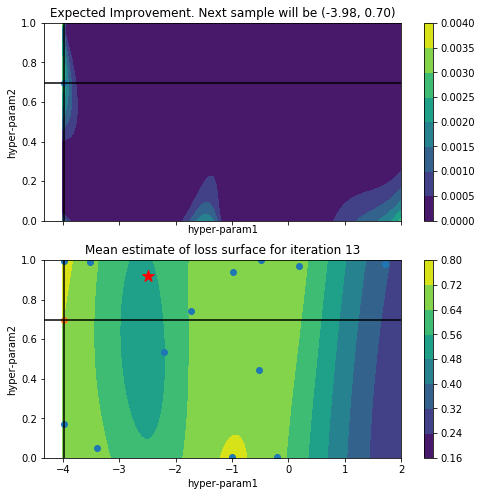

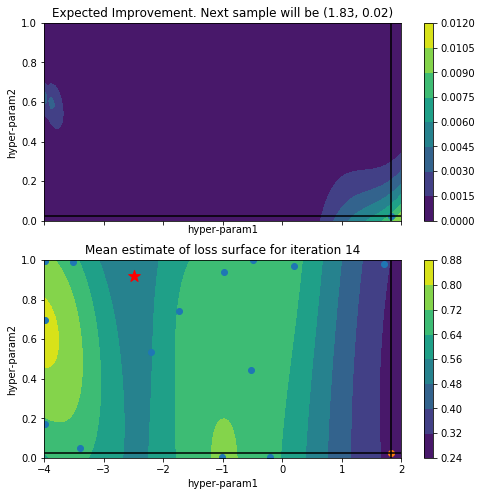

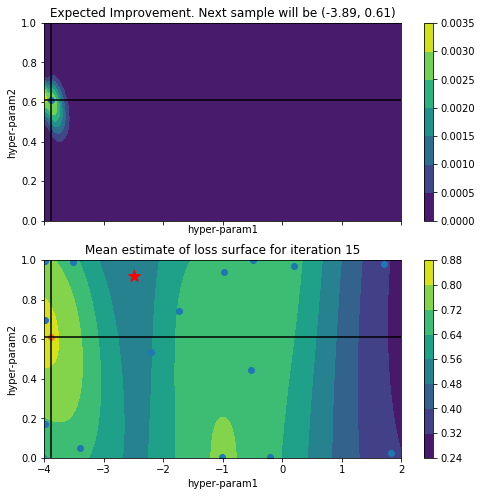

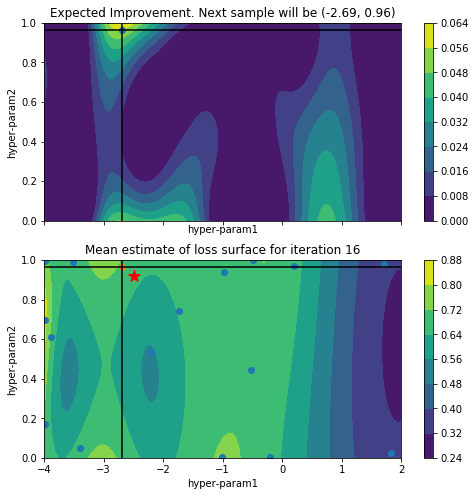

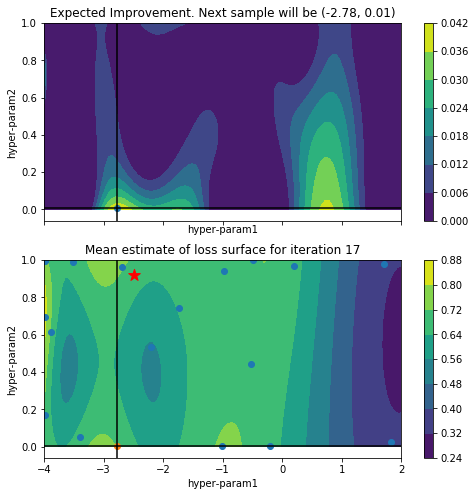

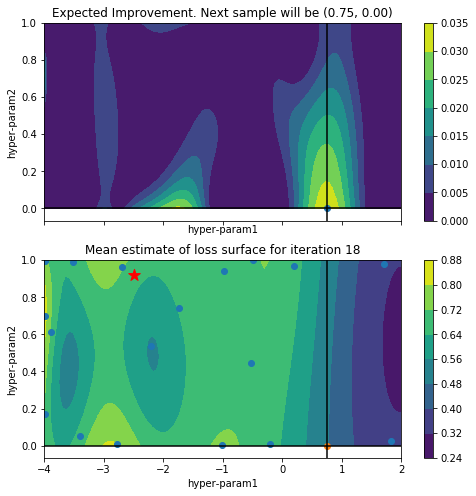

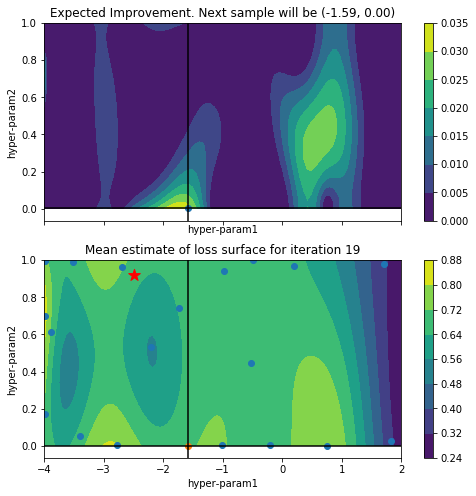

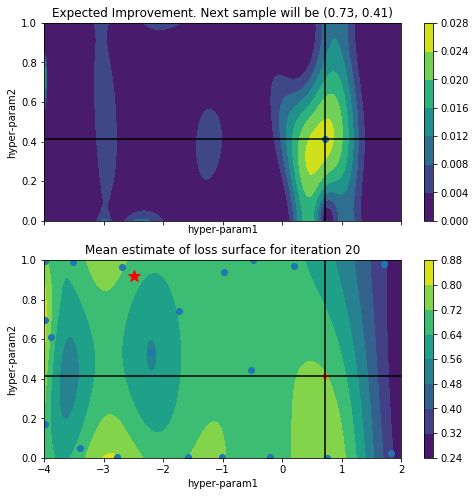

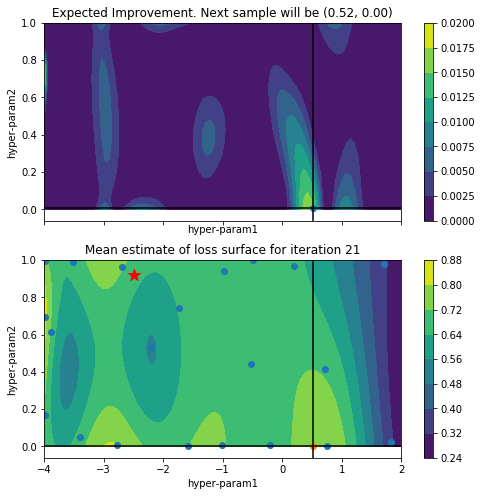

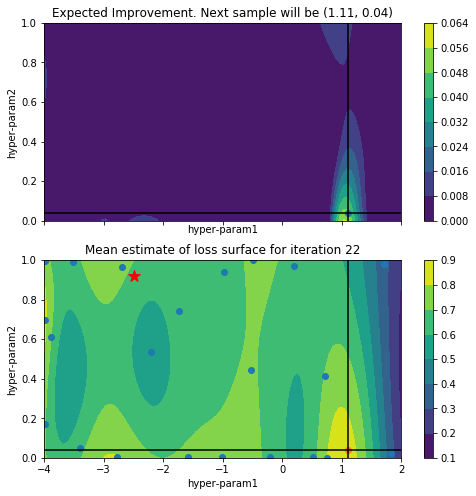

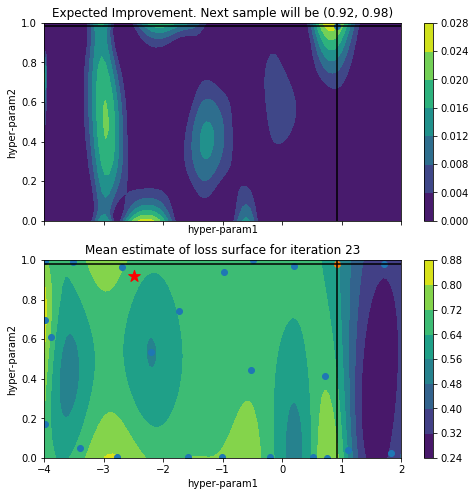

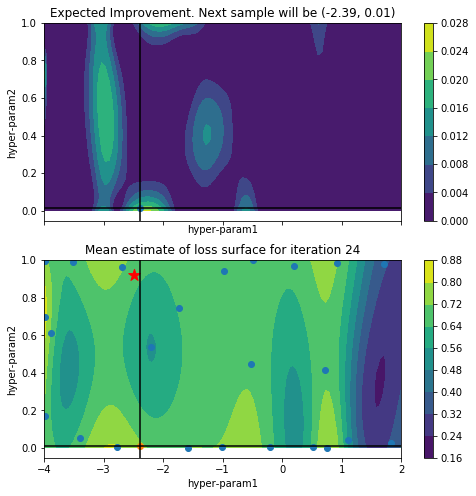

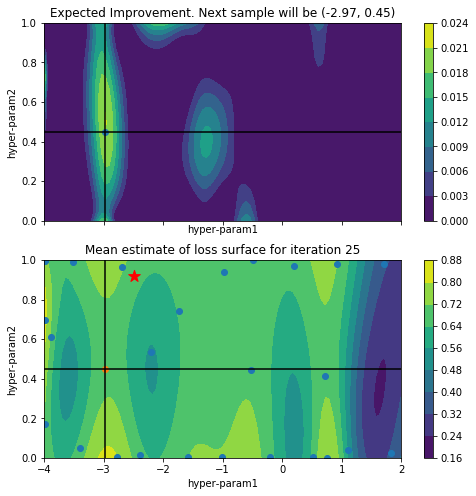

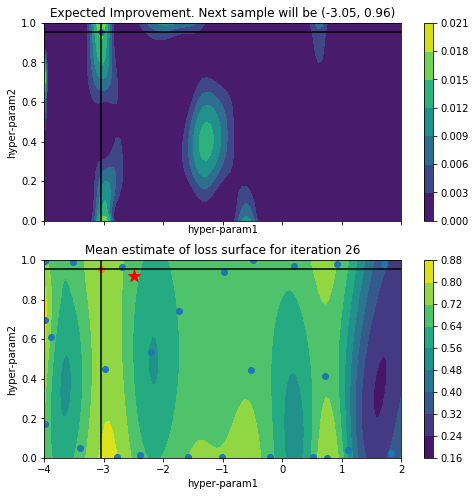

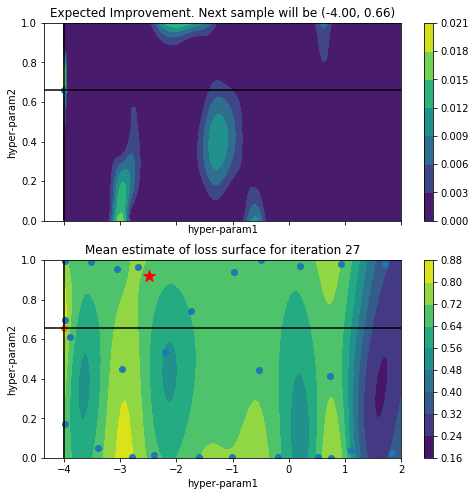

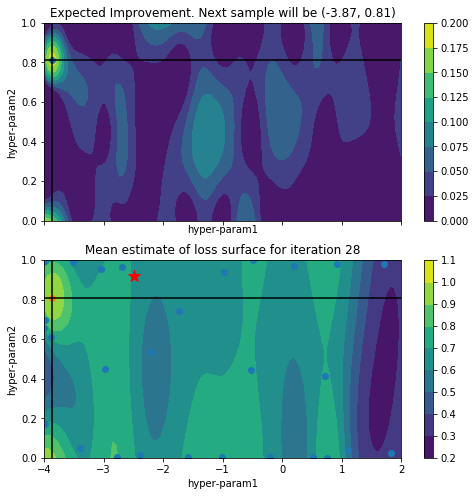

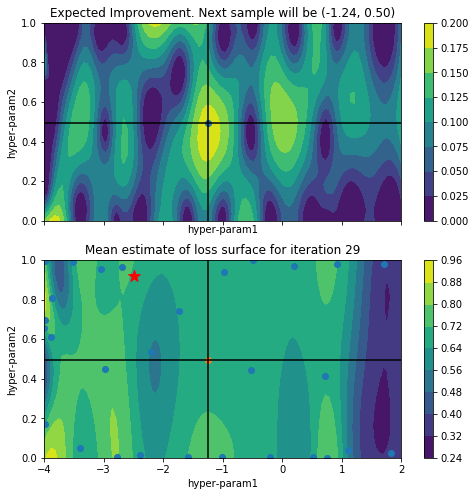

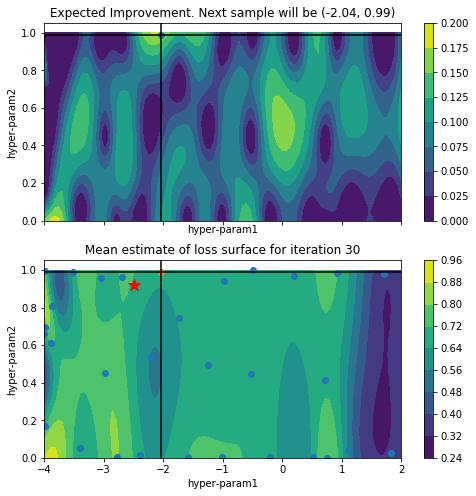

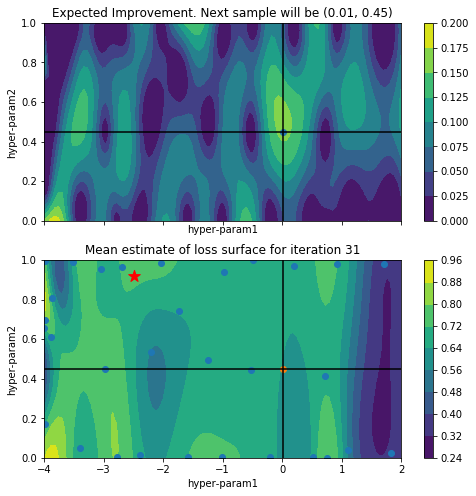

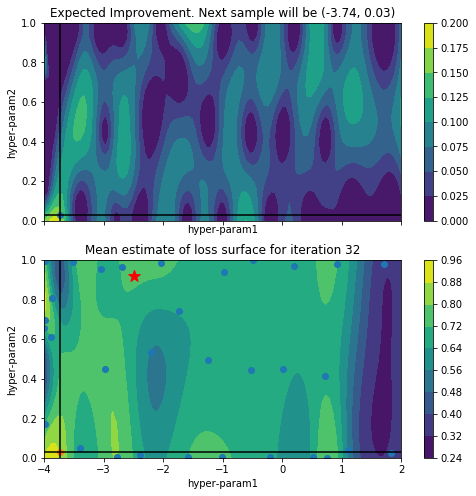

In [9]:
rc('text', usetex=False)
plot_iteration(alphas, xp, yp, first_iter=3, second_param_grid=l1_ratios, optimum=maximum, filepath='.')

On constate que l'algorithme ne tends pas vers le point optimal (étoile rouge) déterminé précedemment. Cependant, le point optimum obtenu lors des dernières itérations se trouve dans une zone iso-valeur plutôt faible ce qui nous conforte dans la convergence de l'algorithme vers des valeurs optimales.

## 2. SVM Classifier (SVC)

Nons appliquons à présent notre algorithme avec le modèle SVC

In [10]:
def sample_loss2(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3).mean()

On cherche une valeur optimale des hyperparamètres indiquée par une étoile rouge sur nos futurs graphes :

In [11]:
# Espace dans lequel va évoluer nos hyperparamètres
Cs = np.linspace(5, -1, 25)
gammas = np.linspace(-1, -7, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss2(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 2.75      , -2.89473684])

On mets en place ci-dessous notre optimisation bayésienne : 

In [12]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-1, 5], [-7, -1]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss2, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

On affiche les résultats obtenus par l'optimisation bayésienne pour la fonction de perte et l'Expected Improovement pour chaque itération : 

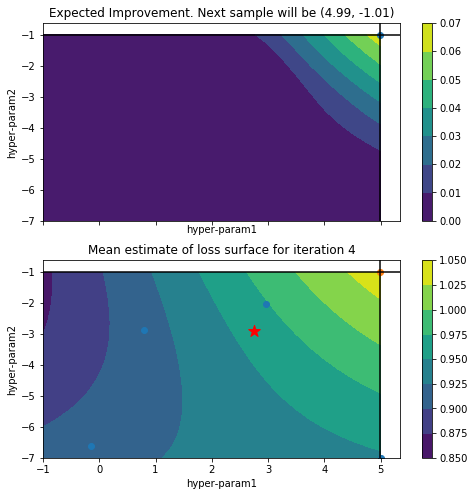

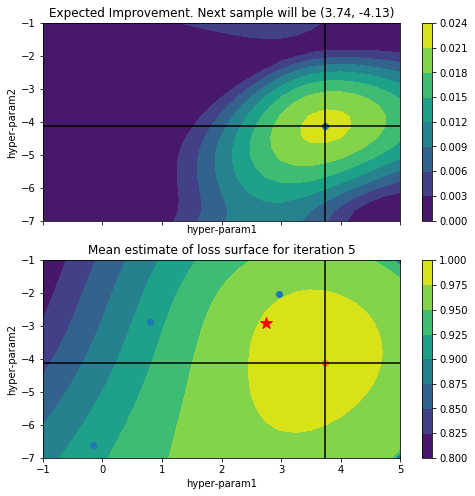

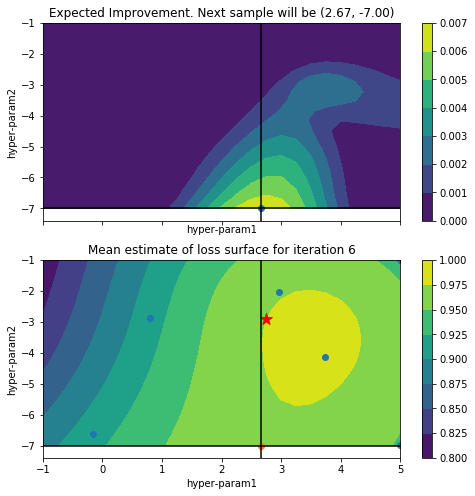

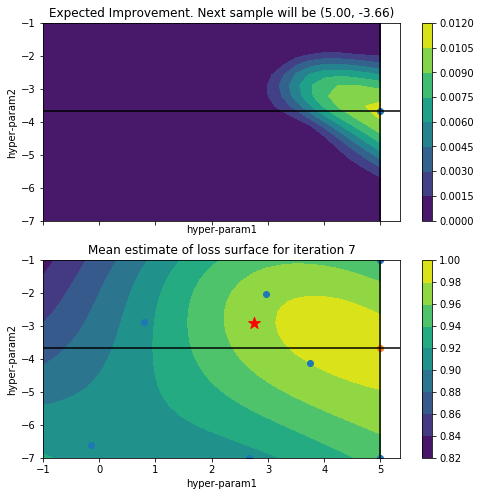

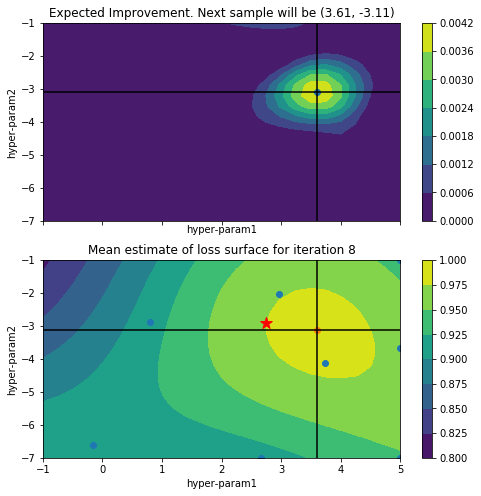

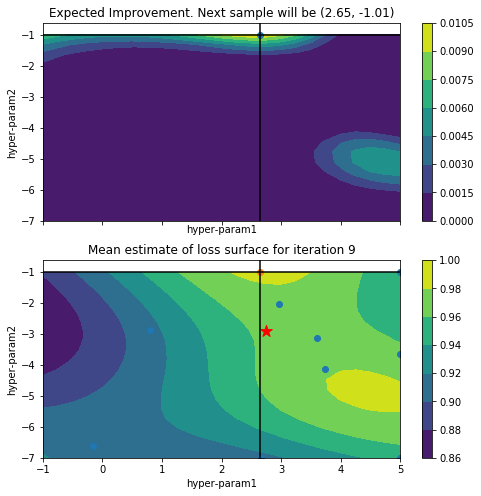

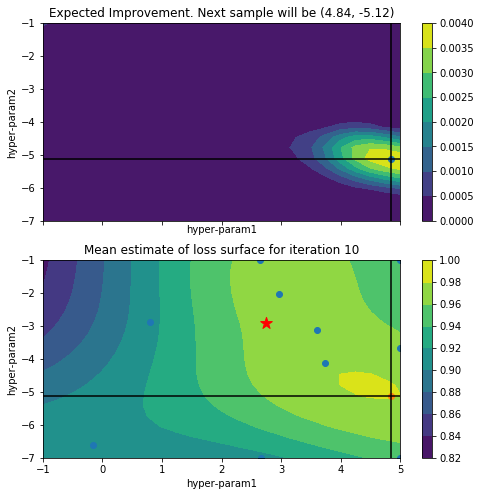

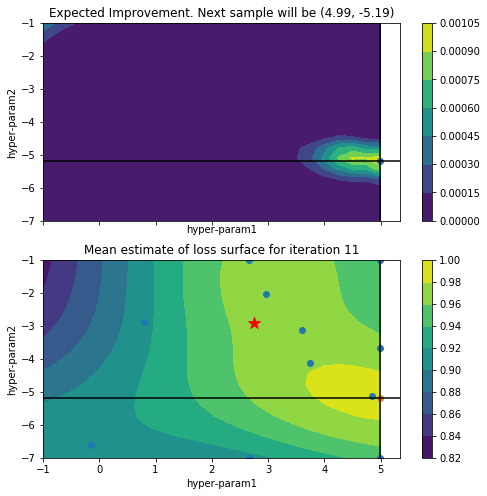

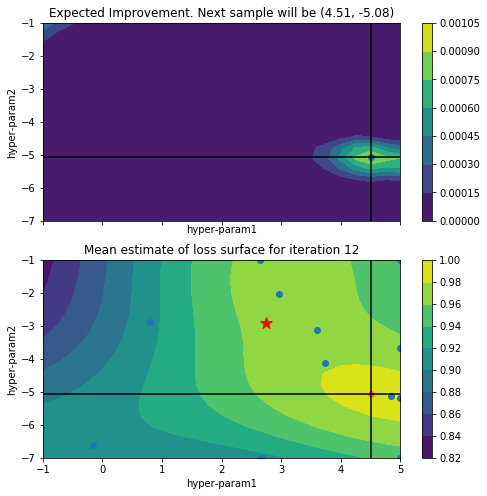

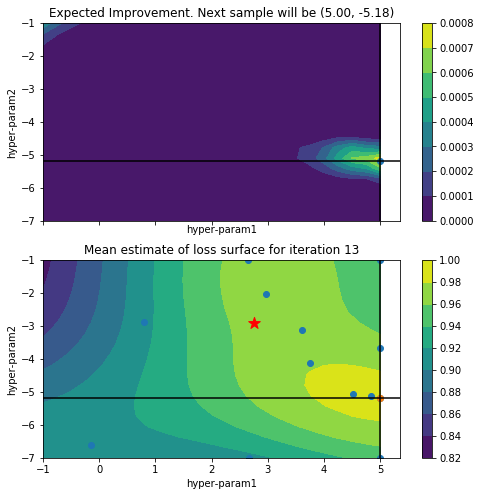

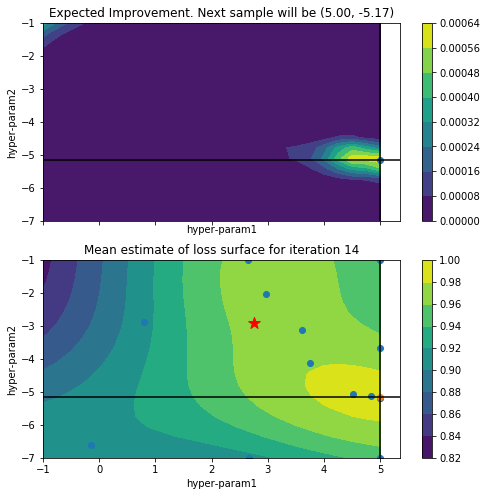

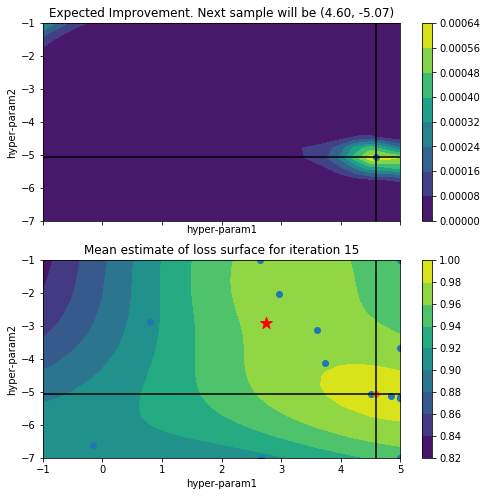

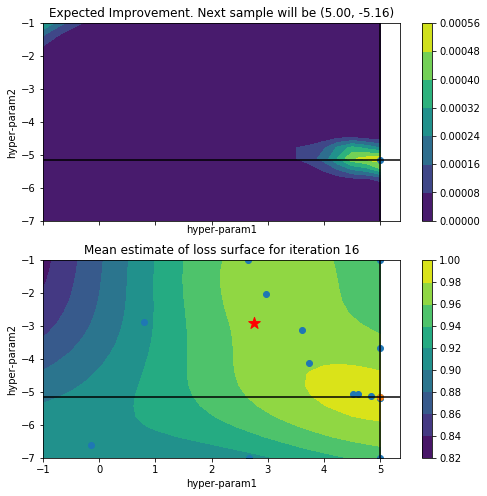

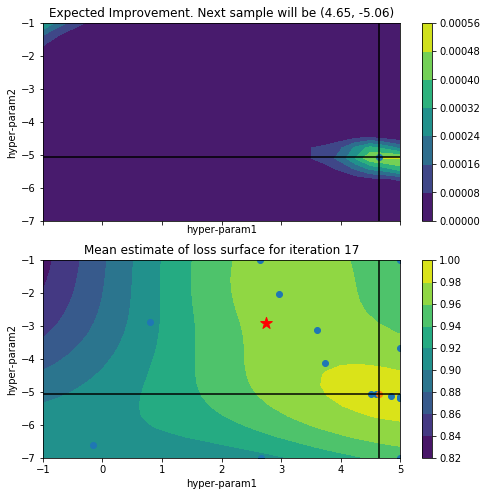

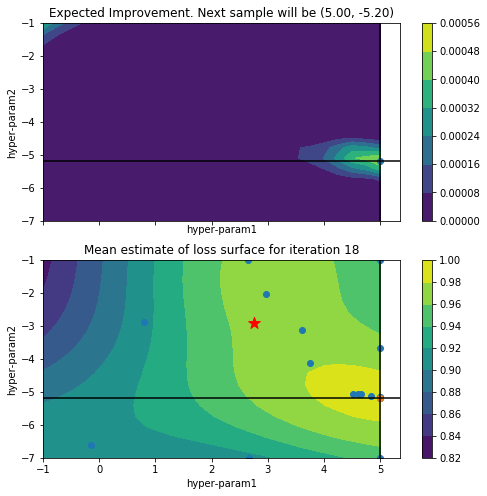

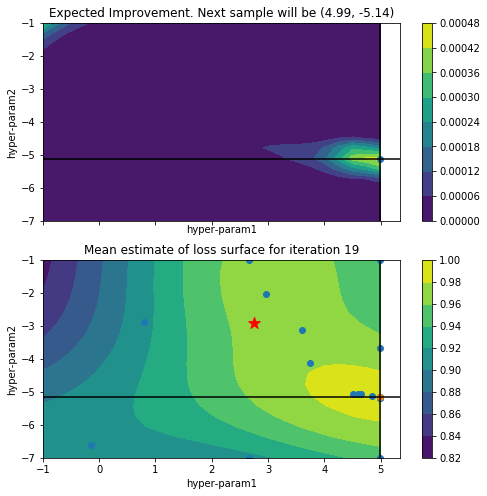

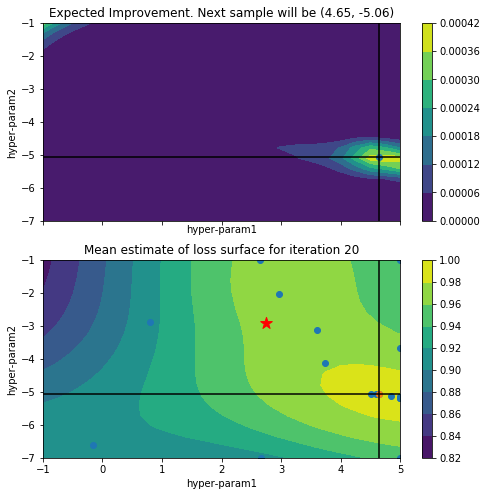

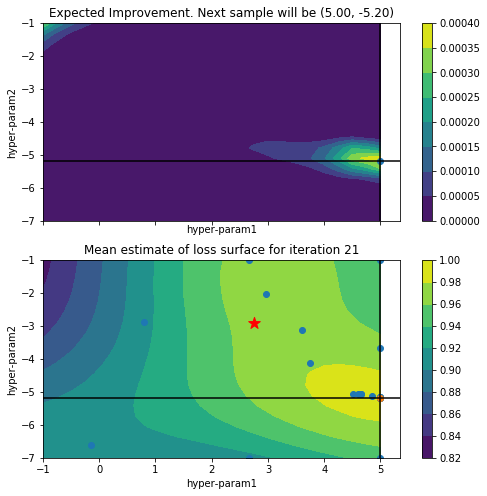

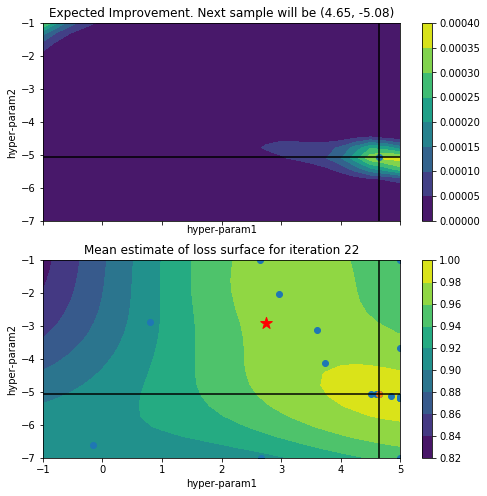

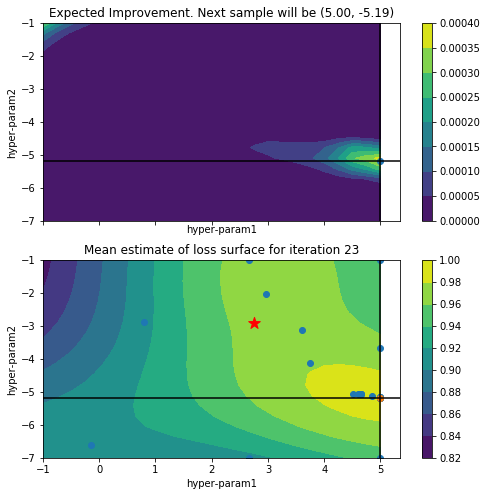

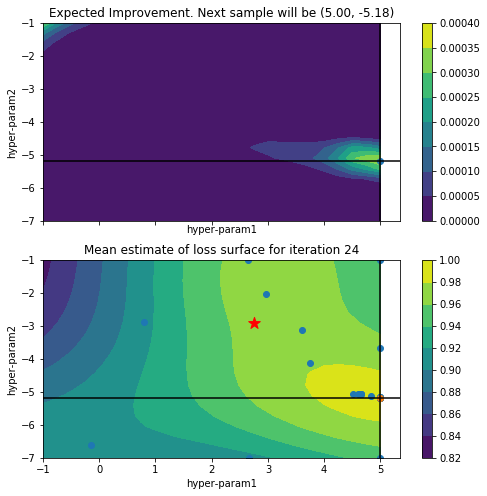

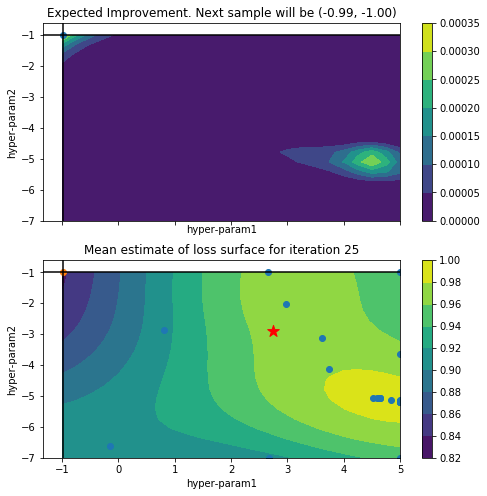

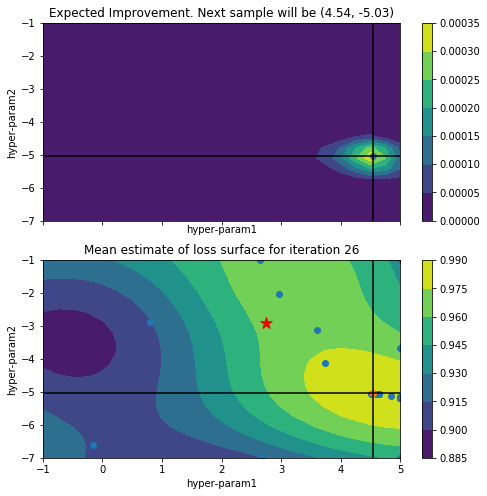

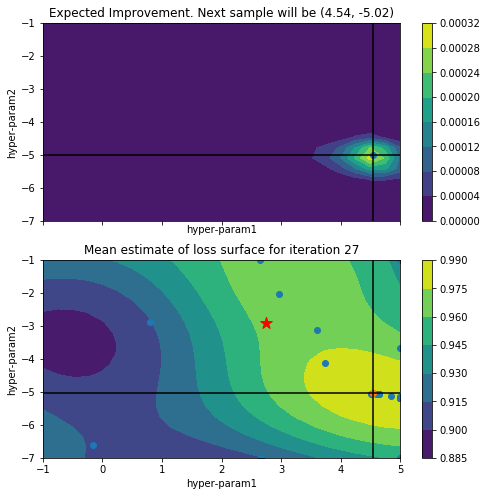

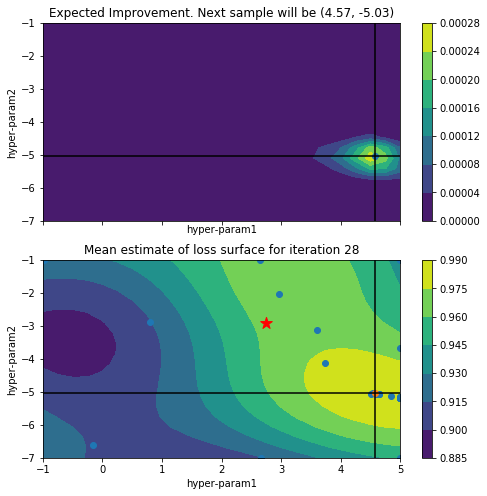

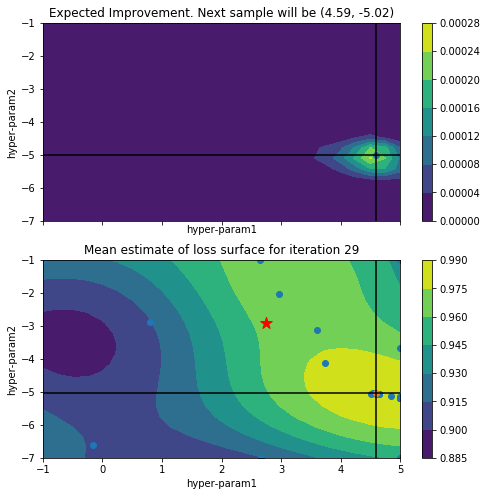

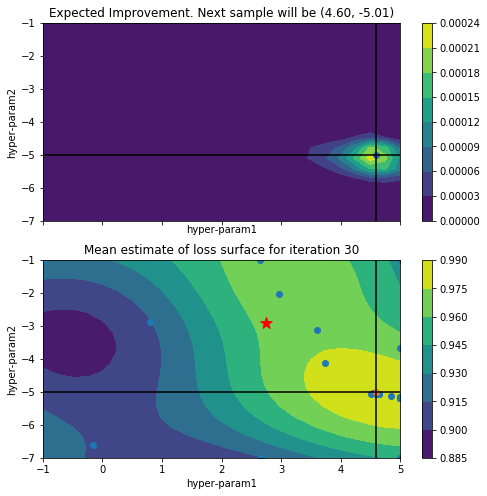

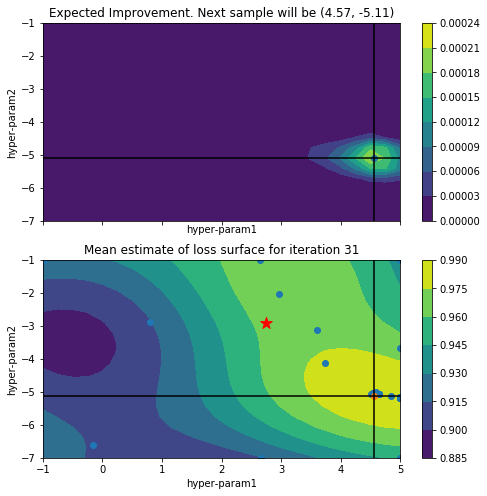

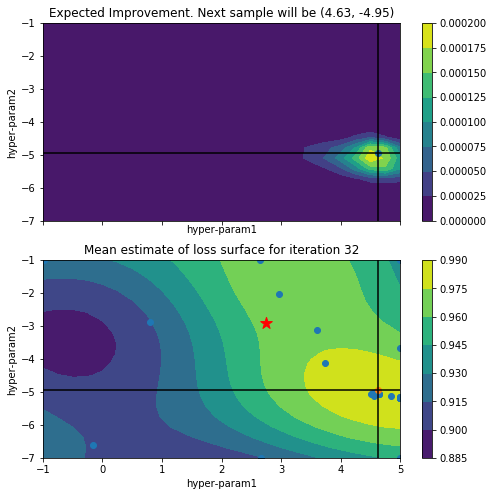

In [13]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')


Ici encore, l'algorithme se trouve dans une zone d'isovaleurs proche de notre objectif.

## 3. Utilisation d'un nouveau dataset de classification binaire (avec make_classification)

On créé cette fois un nouveau dataset sur lequel nous allons appliquer l'algorithme SVC

In [14]:
data, target = datasets.make_classification(n_samples=2000,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

In [15]:
def sample_loss3(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3, scoring='roc_auc').mean()

In [16]:
# Espace dans lequel va évoluer nos hyperparamètres
#Cs = np.linspace(5, -1, 25)
Cs = np.linspace(2, -4, 25)

#gammas = np.linspace(-1, -7, 20)
gammas = np.linspace(2, -4, 20)

# On définit une matrice regroupant toutes les combinaisons des deux variables précédentes
param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])

# On calcule la perte associée à ces hyperparamètres
real_loss = [sample_loss3(params) for params in param_grid]

# On détermine les hyperparamètres "optimaux"
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([ 0.25      , -2.10526316])

In [17]:
# On détermine l'espace dans lequel évolue nos paramètres
bounds = np.array([[-4, 2], [-4, 2]])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss3, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

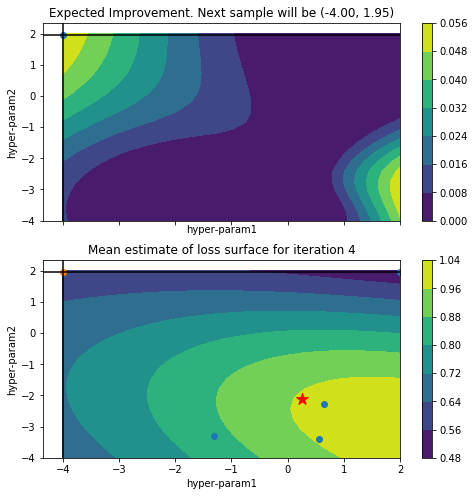

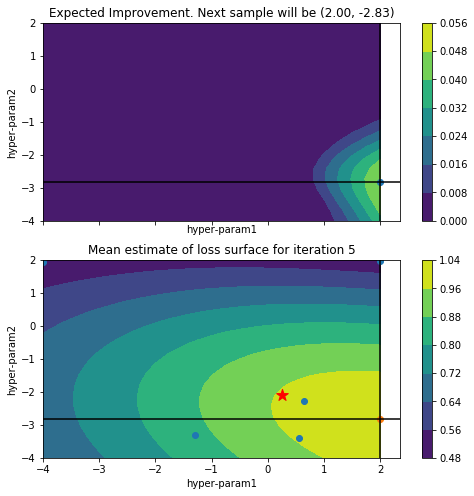

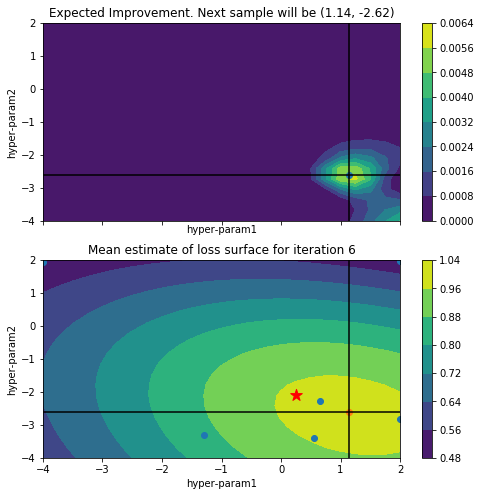

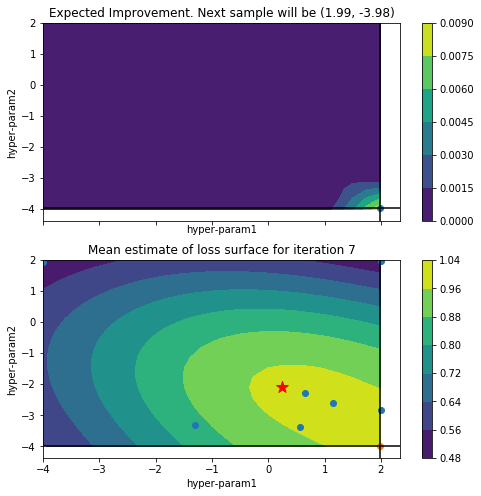

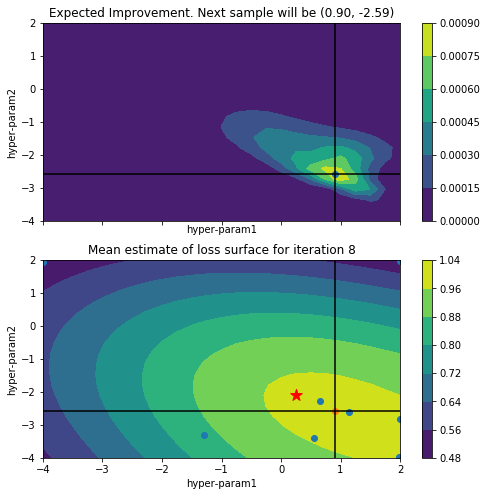

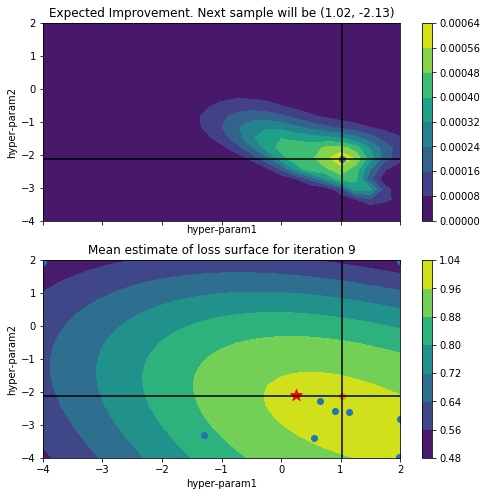

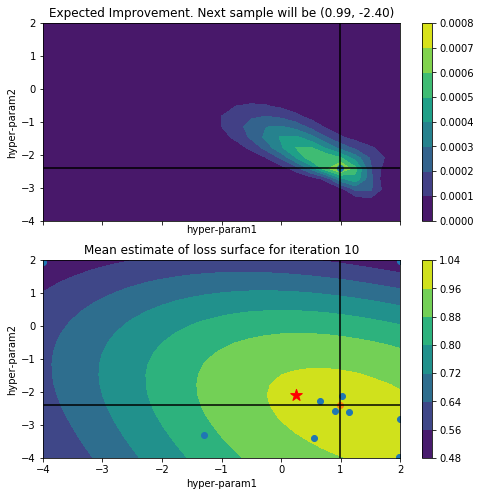

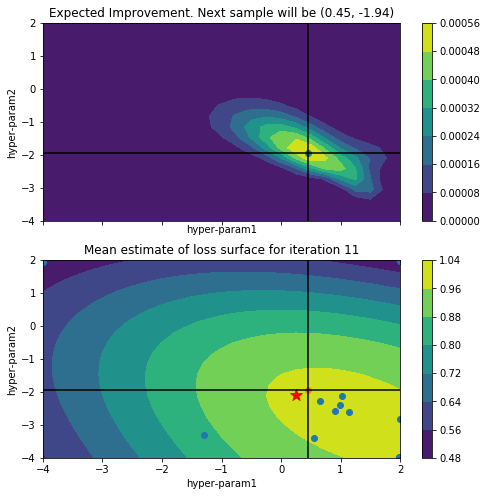

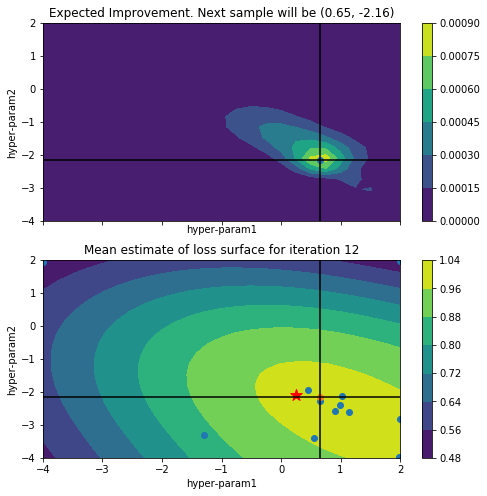

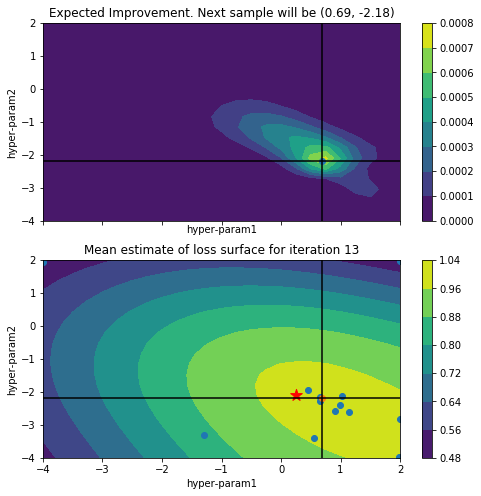

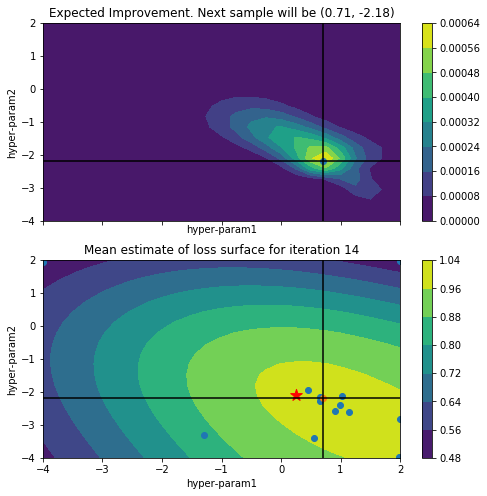

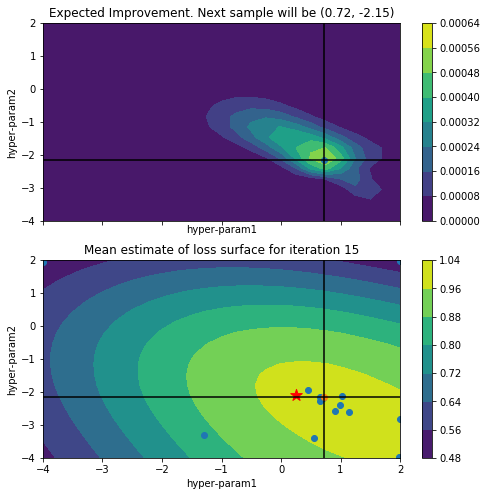

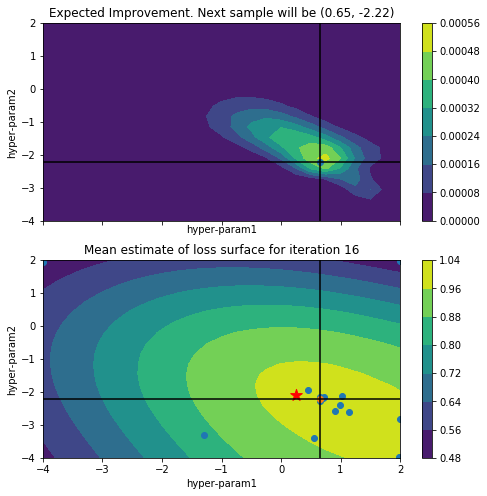

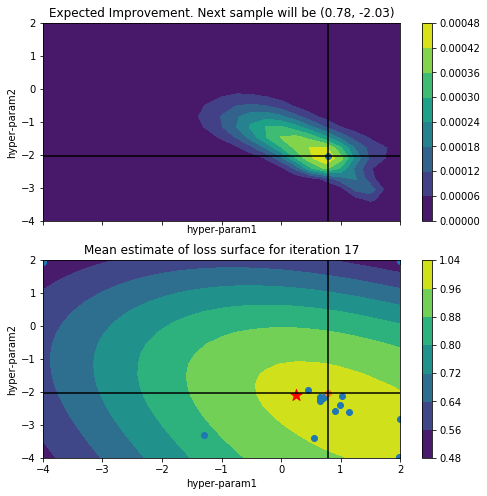

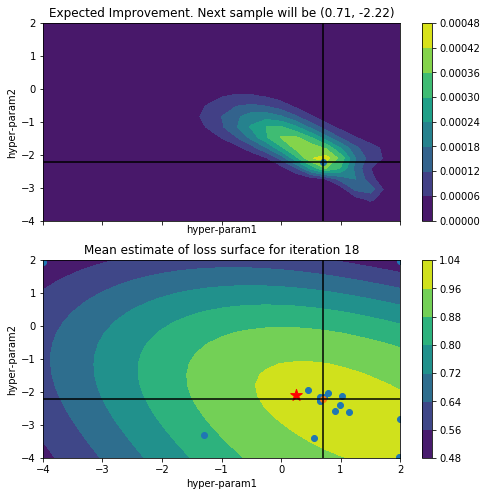

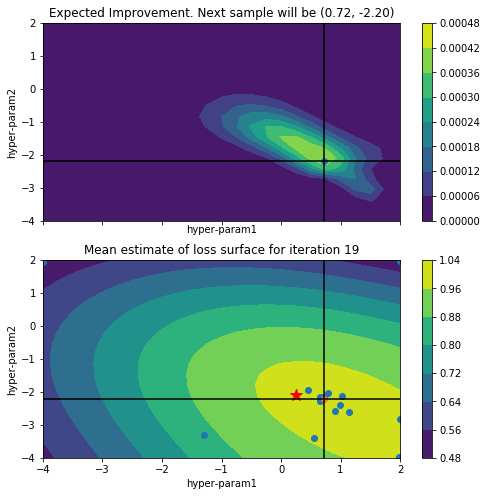

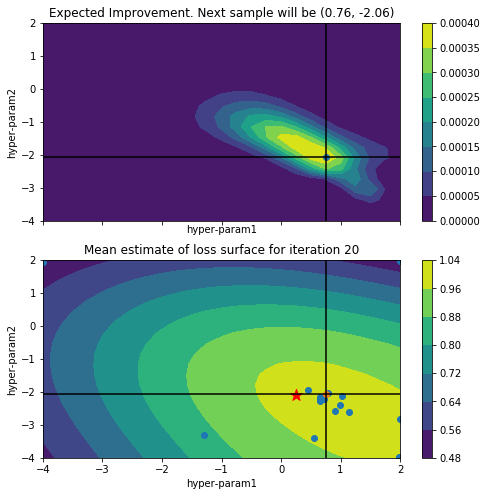

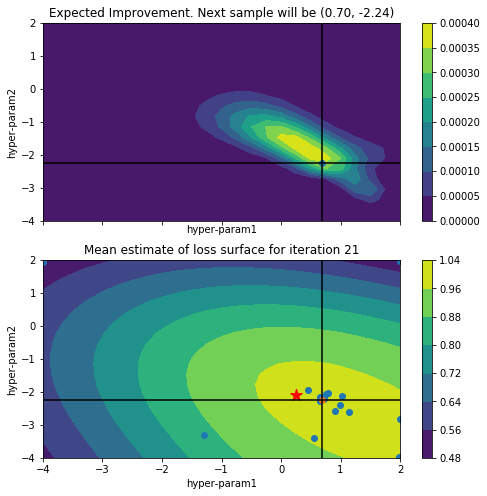

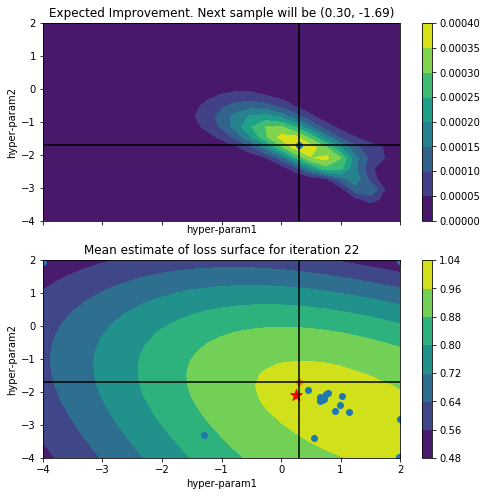

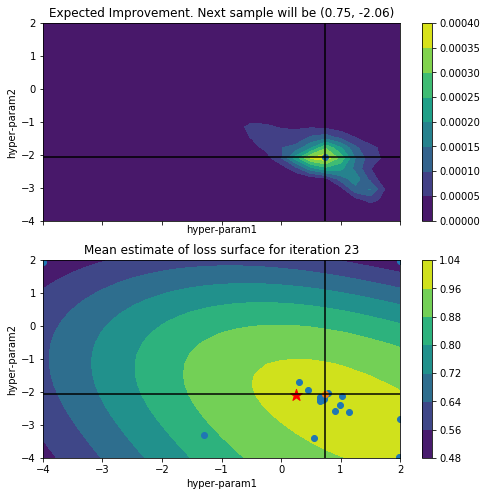

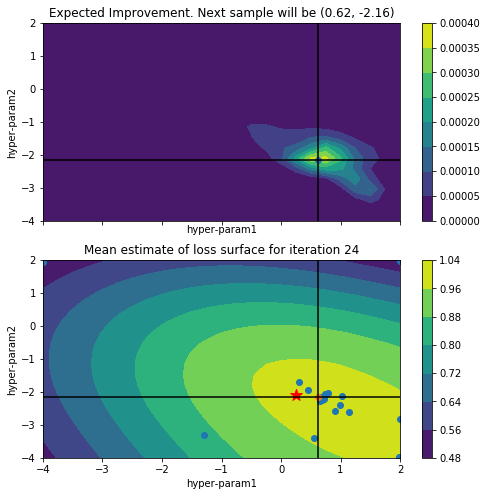

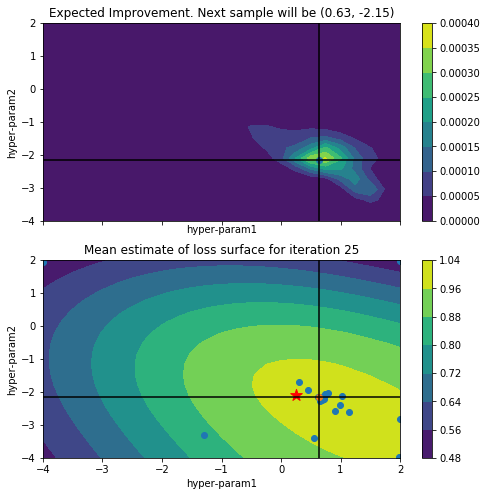

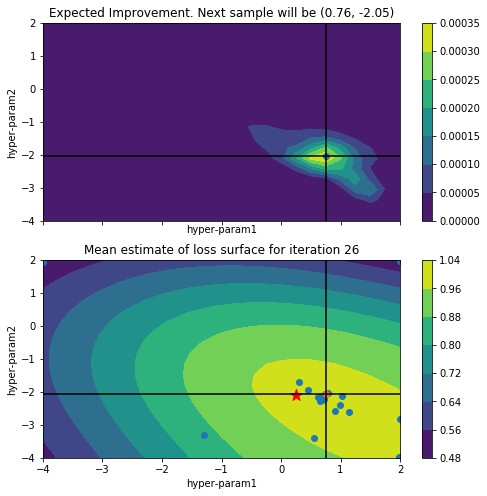

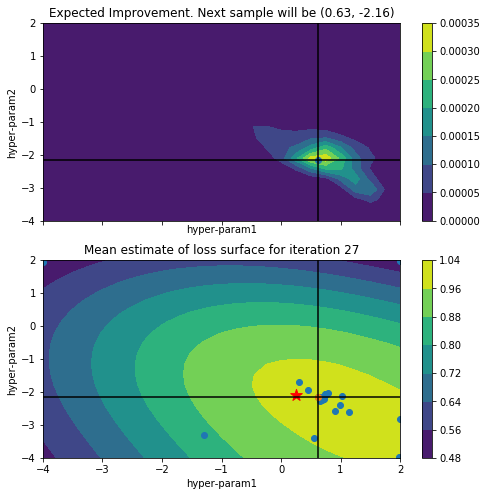

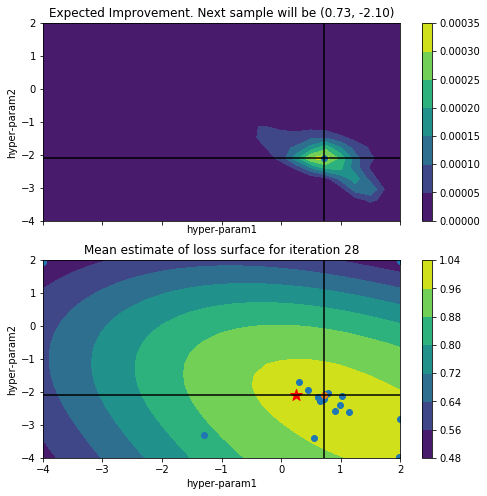

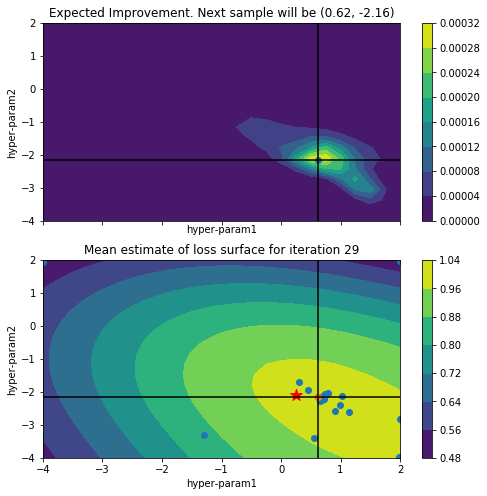

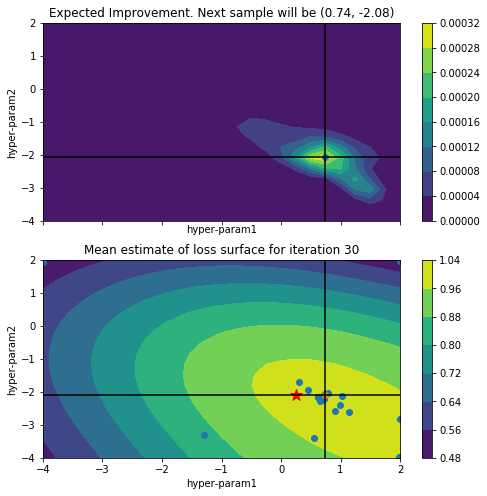

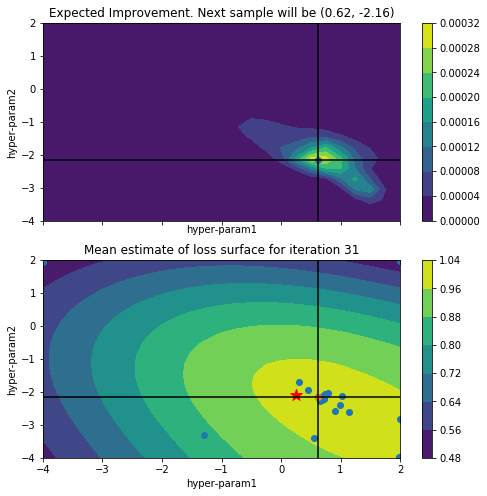

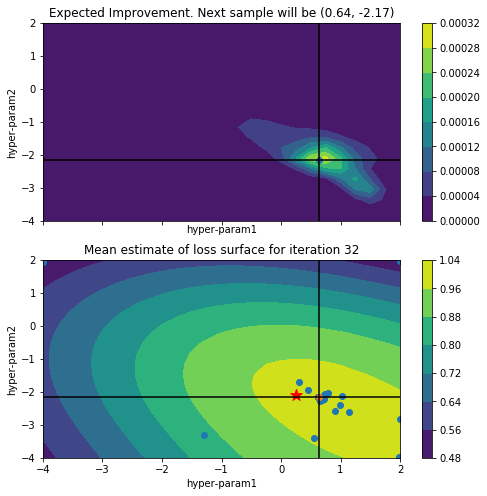

In [18]:
rc('text', usetex=False)

plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')

Dans ce cas, on constate une convergence rapide des hyper-paramètres 1 et 2 vers la valeur théorique calculée.

Le leger éccart avec la "valeur théorique" peut s'expliquer par le fait que celle-ci est choisie parmi un nombre limité de valeurs dans une grille de valeurs (donc sujet à approximation).